In [4]:
# !pip install datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix
import torch
from sklearn.model_selection import train_test_split

In [2]:
# Load full dataset
df = pd.read_csv("Tweets.csv")

# Keep columns we might use later (optional: name, airline, etc.)
keep_cols = ['text', 'airline_sentiment', 'airline', 'negativereason', 
             'airline_sentiment_confidence', 'retweet_count', 'tweet_created']
df = df[keep_cols]

# Drop only rows where required columns are missing
df = df.dropna(subset=['text', 'airline_sentiment'])

# Encode labels properly
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(label_map)

# Optional: fill or tag non-critical NaNs
df['negativereason'] = df['negativereason'].fillna('Unknown')
df['airline'] = df['airline'].fillna('Unknown')
df['airline_sentiment_confidence'] = df['airline_sentiment_confidence'].fillna(0.0)

# Keep only necessary columns for training
df_model = df[['text', 'label']].copy()

print(df_model.head())
print(df_model.label.value_counts())
print(df.head())

                                                text  label
0                @VirginAmerica What @dhepburn said.      1
1  @VirginAmerica plus you've added commercials t...      2
2  @VirginAmerica I didn't today... Must mean I n...      1
3  @VirginAmerica it's really aggressive to blast...      0
4  @VirginAmerica and it's a really big bad thing...      0
label
0    9178
1    3099
2    2363
Name: count, dtype: int64
                                                text airline_sentiment  \
0                @VirginAmerica What @dhepburn said.           neutral   
1  @VirginAmerica plus you've added commercials t...          positive   
2  @VirginAmerica I didn't today... Must mean I n...           neutral   
3  @VirginAmerica it's really aggressive to blast...          negative   
4  @VirginAmerica and it's a really big bad thing...          negative   

          airline negativereason  airline_sentiment_confidence  retweet_count  \
0  Virgin America        Unknown                    

In [5]:
# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Train/Test Split
train_df, test_df = train_test_split(df_model, test_size=0.2, stratify=df_model['label'], random_state=42)

# Tokenization function
def tokenize_function(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Format dataset for Trainer (PyTorch tensors)
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/11712 [00:00<?, ? examples/s]

Map:   0%|          | 0/2928 [00:00<?, ? examples/s]

In [6]:
# Load model for 3-class classification
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

# Training configuration
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",  # Must match save_strategy
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=10
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ajhna\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

C:\Users\ajhna\AppData\Local\Temp\ipykernel_43520\1242746443.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.418300,0.428241
2,0.266800,0.442748
3,0.195900,0.506991


TrainOutput(global_step=2196, training_loss=0.3521910897695302, metrics={'train_runtime': 3612.257, 'train_samples_per_second': 9.727, 'train_steps_per_second': 0.608, 'total_flos': 563070998592576.0, 'train_loss': 0.3521910897695302, 'epoch': 3.0})

In [8]:
# Get predictions
pred_output = trainer.predict(test_dataset)
preds = np.argmax(pred_output.predictions, axis=1)
true = pred_output.label_ids
labels = ['negative', 'neutral', 'positive']

# Classification report
print("Classification Report:\n")
print(classification_report(true, preds, target_names=labels))


Classification Report:

              precision    recall  f1-score   support

    negative       0.87      0.94      0.90      1835
     neutral       0.72      0.60      0.65       620
    positive       0.80      0.76      0.78       473

    accuracy                           0.84      2928
   macro avg       0.80      0.76      0.78      2928
weighted avg       0.83      0.84      0.83      2928



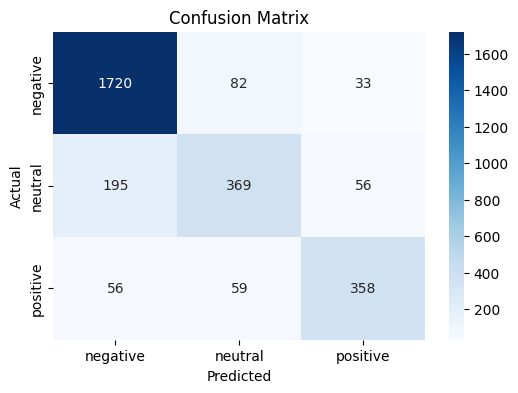

In [9]:
# Confusion matrix
cm = confusion_matrix(true, preds)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
# Convert back to DataFrame for inspection
test_texts = test_dataset['text']
misclassified = []

for i in range(len(true)):
    if true[i] != preds[i]:
        misclassified.append({
            "Text": test_texts[i],
            "True Label": true[i],
            "Predicted": preds[i]
        })

# Create a DataFrame of misclassifications
df_errors = pd.DataFrame(misclassified)

# Map numeric labels to strings for readability
label_map_rev = {0: 'negative', 1: 'neutral', 2: 'positive'}
df_errors['True Label'] = df_errors['True Label'].map(label_map_rev)
df_errors['Predicted'] = df_errors['Predicted'].map(label_map_rev)

# Show 5 examples
df_errors.sample(5)

,Text,True Label,Predicted
73,@AmericanAir v nice of you to give me a breakf...,positive,negative
415,@united I've got a campus visit in an hour and...,neutral,negative
392,"@USAirways yeah, the mark was like a mile back...",negative,positive
278,@JetBlue if only the show was on the flight. ...,negative,neutral
400,"@USAirways Eyyyy! Cancelled Flightlations, Fli...",positive,negative


In [ ]:
# Save the fine-tuned model
model.save_pretrained("saved_model/")
tokenizer.save_pretrained("saved_model/")

In [11]:
from sklearn.utils import resample

# Check original class distribution
print(df_model['label'].value_counts())

# Split into separate classes
neutral_df = df_model[df_model['label'] == 1]
negative_df = df_model[df_model['label'] == 0]
positive_df = df_model[df_model['label'] == 2]

# Upsample neutral class to match negative
neutral_upsampled = resample(neutral_df,
                             replace=True,          # Sample with replacement
                             n_samples=len(negative_df),  # Match negative class count
                             random_state=42)

# Combine with original classes
df_balanced = pd.concat([negative_df, positive_df, neutral_upsampled])

# Shuffle the combined dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new distribution
print(df_balanced['label'].value_counts())

label
0    9178
1    3099
2    2363
Name: count, dtype: int64
label
1    9178
0    9178
2    2363
Name: count, dtype: int64


In [12]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification

# Load Twitter-RoBERTa (note: 3 classes - positive, neutral, negative)
model_name = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer_roberta = RobertaTokenizerFast.from_pretrained(model_name)
model_roberta = RobertaForSequenceClassification.from_pretrained(model_name)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

C:\Users\ajhna\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ajhna\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [13]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Split df_balanced into train/test
train_df, test_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['label'], random_state=42)

# Tokenization function for RoBERTa
def tokenize_roberta(batch):
    return tokenizer_roberta(batch['text'], padding=True, truncation=True)

# Convert to HF Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize
train_dataset = train_dataset.map(tokenize_roberta, batched=True)
test_dataset = test_dataset.map(tokenize_roberta, batched=True)

# Format for Trainer
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/16575 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/4144 [00:00<?, ? examples/s]

In [14]:
from transformers import TrainingArguments, Trainer

training_args_roberta = TrainingArguments(
    output_dir="./results-roberta",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",  # Match save strategy
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    logging_dir="./logs-roberta",
    logging_steps=10
)

C:\Users\ajhna\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
trainer_roberta = Trainer(
    model=model_roberta,
    args=training_args_roberta,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer_roberta
)

# 🚀 Train the model
trainer_roberta.train()

C:\Users\ajhna\AppData\Local\Temp\ipykernel_43520\2081627165.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_roberta = Trainer(


Epoch,Training Loss,Validation Loss
1,0.251400,0.305228
2,0.168600,0.314865
3,0.097100,0.358791


TrainOutput(global_step=3108, training_loss=0.2512779079684496, metrics={'train_runtime': 20098.8714, 'train_samples_per_second': 2.474, 'train_steps_per_second': 0.155, 'total_flos': 2992564651361292.0, 'train_loss': 0.2512779079684496, 'epoch': 3.0})

In [16]:
# Get predictions
pred_output_roberta = trainer_roberta.predict(test_dataset)
preds_roberta = np.argmax(pred_output_roberta.predictions, axis=1)
true_roberta = pred_output_roberta.label_ids

labels = ['negative', 'neutral', 'positive']

# Classification report
print("📊 Classification Report (Twitter-RoBERTa):\n")
print(classification_report(true_roberta, preds_roberta, target_names=labels))


📊 Classification Report (Twitter-RoBERTa):

              precision    recall  f1-score   support

    negative       0.94      0.90      0.92      1836
     neutral       0.89      0.92      0.90      1836
    positive       0.79      0.83      0.81       472

    accuracy                           0.90      4144
   macro avg       0.87      0.88      0.88      4144
weighted avg       0.90      0.90      0.90      4144



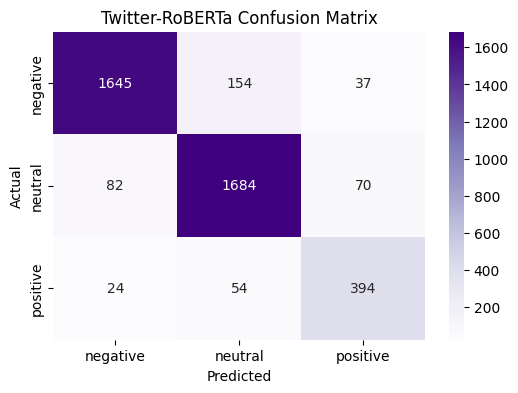

In [17]:
cm_roberta = confusion_matrix(true_roberta, preds_roberta)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title("Twitter-RoBERTa Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [18]:
model.save_pretrained("saved_models/distilbert_sentiment")
tokenizer.save_pretrained("saved_models/distilbert_sentiment")

# For Twitter-RoBERTa
model_roberta.save_pretrained("saved_models/roberta_sentiment")
tokenizer_roberta.save_pretrained("saved_models/roberta_sentiment")

('saved_models/roberta_sentiment\\tokenizer_config.json',
 'saved_models/roberta_sentiment\\special_tokens_map.json',
 'saved_models/roberta_sentiment\\vocab.json',
 'saved_models/roberta_sentiment\\merges.txt',
 'saved_models/roberta_sentiment\\added_tokens.json',
 'saved_models/roberta_sentiment\\tokenizer.json')